In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
path_to_fastai_dev_local = '/home/heye0507/fastai_dev'
sys.path.append(path_to_fastai_dev_local)
sys.path.append('/home/jupyter/.local/bin')
print(sys.version)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [3]:
import torch
torch.__version__

'1.2.0'

In [4]:
from fastai2.basics import *
from fastai2.vision import *
from fastai2.medical.imaging import *

from PIL import Image

np.set_printoptions(linewidth=120)
matplotlib.rcParams['image.cmap'] = 'bone'
set_seed(42)
set_num_threads(1)

In [5]:
path = Path('/home/jupyter/rsns')

In [6]:
path_df = path/'data'
#path_df.ls()

In [7]:
df_lbls = pd.read_feather(path_df/'labels.fth')
df_tst = pd.read_feather(path_df/'df_tst.fth')
df_trn = pd.read_feather(path_df/'df_trn.fth').dropna(subset=['img_pct_window'])
df_trn['fname'] = df_trn['fname'].apply(lambda x: str(path)+'/data/raw/stage_1_train_images/' + str(Path(x).stem) + '.dcm')
df_tst['fname'] = df_tst['fname'].apply(lambda x: str(path)+'/data/raw/stage_1_test_images/' + str(Path(x).stem) + '.dcm')
comb = df_trn.join(df_lbls.set_index('ID'),'SOPInstanceUID')

In [8]:
repr_flds = ['BitsStored','PixelRepresentation']
df1 = comb.query('(BitsStored==12) & (PixelRepresentation==0)')
df2 = comb.query('(BitsStored==12) & (PixelRepresentation==1)')
df3 = comb.query('BitsStored==16')
dfs = L(df1,df2,df3)

# Damaged

In [10]:
def df2dcm(df): return L(Path(o).dcmread() for o in df.fname.values)

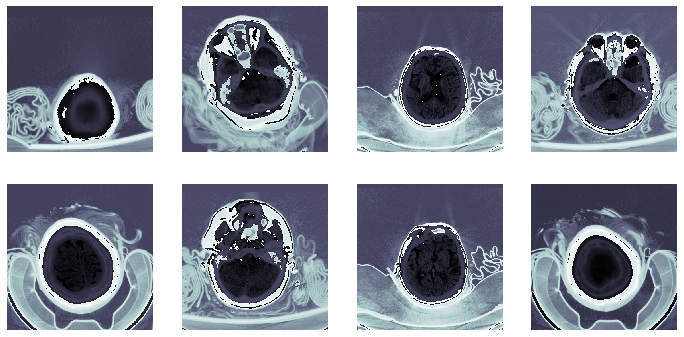

In [11]:
df_iffy = df1[df1.RescaleIntercept>-100]
dcms = df2dcm(df_iffy)

_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): dcms[i].show(ax=ax)

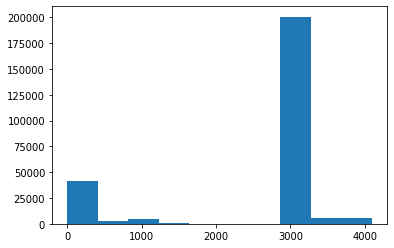

In [12]:
dcm = dcms[2]
d = dcm.pixel_array
plt.hist(d.flatten());

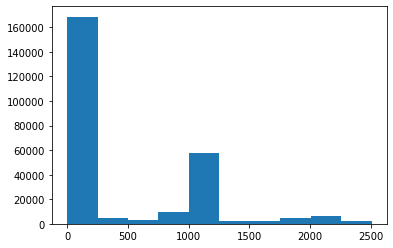

In [13]:
d1 = df2dcm(df1.iloc[[0]])[0].pixel_array
plt.hist(d1.flatten());

In [14]:
scipy.stats.mode(d.flatten()).mode[0]

3096

In [15]:
d += 1000

px_mode = scipy.stats.mode(d.flatten()).mode[0]
d[d>=px_mode] = d[d>=px_mode] - px_mode
dcm.PixelData = d.tobytes()
dcm.RescaleIntercept = -1000

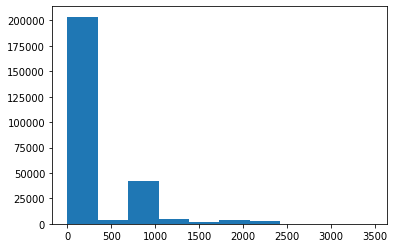

In [16]:
plt.hist(dcm.pixel_array.flatten());

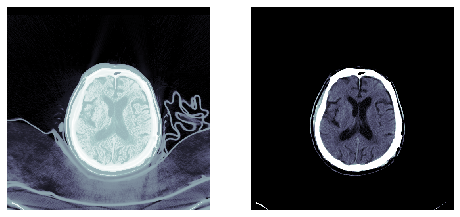

In [17]:
_,axs = subplots(1,2)
dcm.show(ax=axs[0]);   dcm.show(dicom_windows.brain, ax=axs[1])


In [7]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

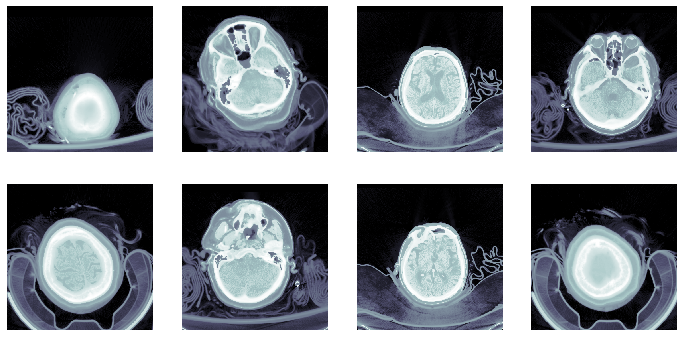

In [19]:
dcms = df2dcm(df_iffy)
dcms.map(fix_pxrepr)

_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): dcms[i].show(ax=ax)

In [20]:
df_iffy.img_pct_window[:10].values

array([0.03567886, 0.14665604, 0.1501503 , 0.18796158, 0.09502792, 0.17225647, 0.15142441, 0.02574921, 0.14790726,
       0.15719604])

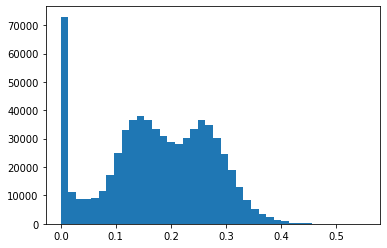

In [21]:
plt.hist(comb.img_pct_window,40);

In [22]:
comb = comb.assign(pct_cut = pd.cut(comb.img_pct_window, [0,0.02,0.05,0.1,0.2,0.3,1]))
comb.pivot_table(values='any', index='pct_cut', aggfunc=['sum','count']).T

,pct_cut,"(0.0, 0.02]","(0.02, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 1.0]"
sum,any,61,696,3312,21137,55437,16459
count,any,70673,19706,45886,241859,226345,61798


# Create subset

In [22]:
comb.drop(comb.query('img_pct_window<0.02').index, inplace=True)

In [23]:
df_lbl = comb.query('any==True')
n_lbl = len(df_lbl)
n_lbl

97041

In [24]:
df_nonlbl = comb.query('any==False').sample(n_lbl//2)
len(df_nonlbl)

48520

In [25]:
comb = pd.concat([df_lbl,df_nonlbl])
len(comb)

145561

# Skip the above to create full dataset

In [8]:
len(comb)

674257

In [26]:
comb.head()

,SOPInstanceUID,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,...,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,pct_cut
0,ID_231d901c1,CT,ID_b81a287f,ID_dd37ba3adb,ID_15dcd6057a,,-125.0,1.0,1,MONOCHROME2,...,NaN,NaN,NaN,1,0,0,0,1,0,"(0.1, 0.2]"
12,ID_019fca83f,CT,ID_a6882fde,ID_a06a9a18ce,ID_545f0fb9b1,,-125.0,1.0,1,MONOCHROME2,...,NaN,NaN,NaN,1,0,0,0,1,0,"(0.2, 0.3]"
19,ID_bab3d55d5,CT,ID_1ce79b2e,ID_55f72c7bad,ID_3ee2dc53e7,,-125.0,1.0,1,MONOCHROME2,...,NaN,NaN,NaN,1,1,0,0,1,0,"(0.2, 0.3]"
22,ID_929cbea19,CT,ID_657fbcb3,ID_c4d29f2047,ID_4f14b399c4,,-173.0,1.0,1,MONOCHROME2,...,40.0,1.0,80.0,1,0,1,1,0,0,"(0.1, 0.2]"
25,ID_a5387e47d,CT,ID_8c9bf219,ID_341f6cbe22,ID_6356f1b6f7,,-128.5,1.0,1,MONOCHROME2,...,NaN,NaN,NaN,1,0,0,0,1,0,"(0.2, 0.3]"


In [27]:
dcm = Path(dcms[3].filename).dcmread()
fix_pxrepr(dcm)

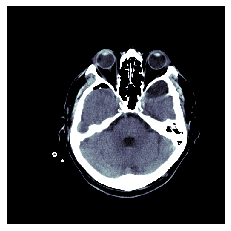

In [28]:
px = dcm.windowed(*dicom_windows.brain)
show_image(px,cmap='bone');

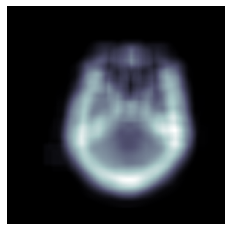

In [29]:
blurred = gauss_blur2d(px, 100)
show_image(blurred,cmap='bone');

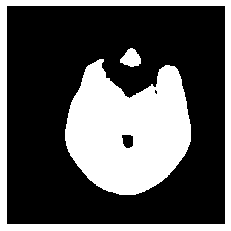

In [30]:
show_image(blurred>0.3,cmap='bone');

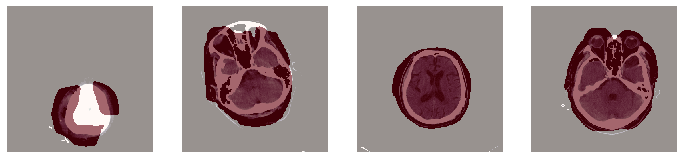

In [31]:
_,axs = subplots(1,4, imsize=3)
for i,ax in enumerate(axs.flat):
    dcms[i].show(dicom_windows.brain, ax=ax)
    show_image(dcms[i].mask_from_blur(dicom_windows.brain), cmap=plt.cm.Reds, alpha=0.6, ax=ax)

In [9]:
def pad_square(x):
    r,c = x.shape
    d = (c-r)/2
    pl,pr,pt,pb = 0,0,0,0
    if d>0: pt,pd = int(math.floor( d)),int(math.ceil( d))        
    else:   pl,pr = int(math.floor(-d)),int(math.ceil(-d))
    return np.pad(x, ((pt,pb),(pl,pr)), 'minimum')

def crop_mask(x):
    mask = x.mask_from_blur(dicom_windows.brain)
    bb = mask2bbox(mask)
    if bb is None: return
    lo,hi = bb
    cropped = x.pixel_array[lo[0]:hi[0],lo[1]:hi[1]]
    x.pixel_array = pad_square(cropped)

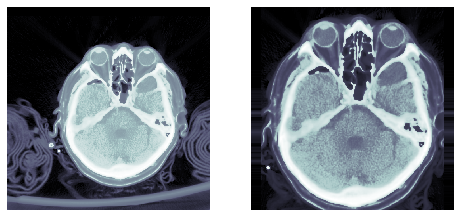

In [33]:
_,axs = subplots(1,2)
dcm.show(ax=axs[0],cmap='bone')
crop_mask(dcm)
dcm.show(ax=axs[1],cmap='bone');

In [14]:
htypes = 'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural'

def get_samples(df):
    recs = [df.query(f'{c}==1').sample() for c in htypes]
    recs.append(df.query('any==0').sample())
    return pd.concat(recs).fname.values

sample_fns = concat(*dfs.map(get_samples))
sample_dcms = tuple(Path(o).dcmread().scaled_px for o in sample_fns)
samples = torch.stack(sample_dcms)
bins = samples.freqhist_bins()

In [16]:
len(sample_fns)

21

In [17]:
path_dest = path/'data/preprocessed'
#path_dest.ls()

In [27]:
(path_dest/'bins.pkl').save(bins)

In [19]:
def dcm_tfm(fn): 
    fn = Path(fn)
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    return x.scaled_px

In [20]:
fns = list(comb.fname.values)
dest = path_dest/'full_train_jpg'
dest.mkdir(exist_ok=True)
# NB: Use bs=512 or 1024 when running on GPU
bs=1024

dsrc = DataSource(fns, [[dcm_tfm],[os.path.basename]])
dl = TfmdDL(dsrc, bs=bs, num_workers=8)

In [39]:
# x,y = next(iter(dl))
# x.shape

In [40]:
# x = to_device(x)
# x.device

In [21]:
def dest_fname(fname): return dest/Path(fname).with_suffix('.jpg')

def save_cropped_jpg(o, dest):
    fname,px = o
    px.save_jpg(dest_fname(fname), dicom_windows.brain, dicom_windows.subdural, bins=bins)

In [22]:
def process_batch(pxs, fnames, n_workers=4):
    pxs = to_device(pxs)
    masks = pxs.mask_from_blur(dicom_windows.brain)
    bbs = mask2bbox(masks).type(torch.float)
    gs = crop_resize(pxs, bbs, 512).cpu().squeeze()
    parallel(save_cropped_jpg, zip(fnames, gs), n_workers=n_workers, progress=False, dest=dest)

In [23]:
# test and time a single batch. It's ~100x faster on a GPU!
%time process_batch(*dl.one_batch(), n_workers=2)

RuntimeError: CUDA out of memory. Tried to allocate 6.00 GiB (GPU 0; 14.73 GiB total capacity; 2.25 GiB already allocated; 1.55 GiB free; 5.00 GiB cached)

In [62]:
fn = dest.ls()[0]
im = Image.open(fn)
fn

PosixPath('/home/jupyter/rsns/data/train_jpg/ID_231d901c1.jpg')

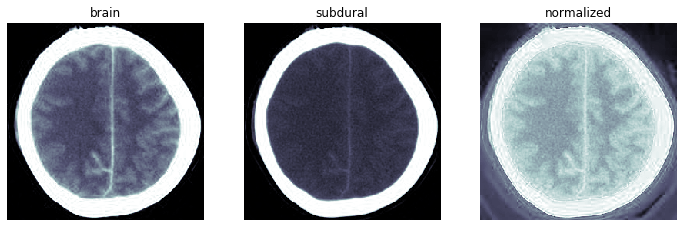

In [67]:
show_images(tensor(im).permute(2,0,1), titles=['brain','subdural','normalized'])

In [60]:
fn

PosixPath('/home/jupyter/rsns/data/train_jpg/ID_231d901c1.jpg')

In [ ]:
dest.mkdir(exist_ok=True)
for b in progress_bar(dl): process_batch(*b, n_workers=8)

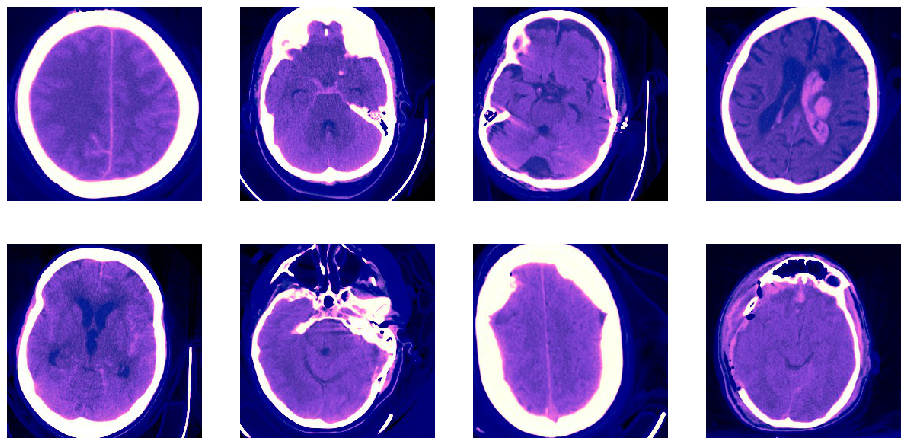

In [54]:
# Uncomment this to view some processed images

for i,(ax,fn) in enumerate(zip(subplots(2,4)[1].flat,fns)):
    jpgfn = dest/Path(fn).with_suffix('.jpg').name
    a = Image.open(jpgfn)
    #a = jpgfn.jpg16read()
    show_image(a,ax=ax)